In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import  add_xmonth_default_flag
import warnings
plt.style.use('ggplot')

# Part 1. Data processing

## Task 1.1: data cleaning

### Summary ###
**Problems found**:
<br>
1. monthly_outcome.csv<br>
    1.a Status: Mixing floats and ints to codify same information (e.g. 1.0, 1) -> Converted floats to int and replace 'D' with 4<br>
    1.b Status: Status corrupted for some users, should increase by 0 or 1 but sometimes jumps by  more than 1 or even decreases-> Drop unique_ids where status corrupted (13K)<br>
    1.c Date: Convert to datetime<br>
    <br>
2. application.csv<br>
    2.a Duplicated rows -> Drop (5K)<br>
    2.b Implausible negative numbers for some numerical features (e.g. -9999999.0) -> Set values to NULL as rows otherwise useful<br>
        (impacted features: age_oldest_account, total_value_of_mortgage, current_utilisation, months_since_2_payments_missed, number_of_credit_searches_last_3_months)<br>
    3.c Missing values for is_bad_12m -> Calculated correct values and replaced nulls (4K)
<br>

**Complete set of checks (Code in 'data_cleaning.ipynb' for easier reading)**:<br>
1. Datatypes<br>
2. Nulls<br>
3. Status column:<br>
    3.a Checked unique values<br>
    3.b Is there exactly 12 payback events for each customer? -> yes<br>
    3.c Always 1 month between payback events per customer? -> yes<br>
    3.d Status always increases by 0 or 1? (It has to) -> No, fixed<br>
4. is_12m_bad column:<br>
    4.a Missing values -> fixed by calculating correct values<br>
5. Dates: <br>
    5.a Cast to datetime <br>
    5.b Confirm data size over time (development, monitor, post-deployment) -> Looks reasonable<br>
6. Unique_id col:<br>
    6.a Duplicates in application.csv, perfect copy of rows -> Dropped<br>
    6.b Confirm that unique_ids between 2 datasets match 1 to 1 -> Matches, no fix needed<br>
7. Numerical features<br>
    7.a Plot distributions (after replacing implausible values) -> Fixed, reasonable distributions<br>

In [62]:
mo_df = pd.read_csv("./data/monthly_outcome.csv")
ap_df = pd.read_csv("./data/application.csv")

### 1. Data Types ###

**Results:**
1. status: object -> Suggests mixed data types, explore
2. date, origination_date: object -> Cast to datetime

In [63]:

print("Data types for mo_df:")
print(mo_df.dtypes)

print("\nData types for ap_df:")
print(ap_df.dtypes)


Data types for mo_df:
unique_id     int64
date         object
status       object
dtype: object

Data types for ap_df:
unique_id                                    int64
stress_score                               float64
is_bad_12m                                 float64
model_1                                    float64
model_2                                    float64
origination_date                            object
loan_term                                  float64
loan_amount                                float64
age_oldest_account                         float64
total_value_of_mortgage                    float64
current_utilisation                        float64
months_since_2_payments_missed             float64
number_of_credit_searches_last_3_months    float64
dtype: object


### 2. NULLS ###
**Results**
1. 9K NULL values for is_bad_12m -> Unexpected -> Investigate
2. 100K for stress_scored -> Expected as variable only available later on (Won't dig deeper)

In [64]:
print('---- monthly_outcome.csv ----')
print(f'Nulls or NAs per column in monthly_outcome.csv:\n',mo_df.isnull().sum())
print('---- application.csv ----')
print(f'Nulls or NAs per column in application.csv:\n',ap_df.isnull().sum())


---- monthly_outcome.csv ----
Nulls or NAs per column in monthly_outcome.csv:
 unique_id    0
date         0
status       0
dtype: int64
---- application.csv ----
Nulls or NAs per column in application.csv:
 unique_id                                      0
stress_score                               48030
is_bad_12m                                  4562
model_1                                        0
model_2                                        0
origination_date                               0
loan_term                                      0
loan_amount                                    0
age_oldest_account                             0
total_value_of_mortgage                        0
current_utilisation                            0
months_since_2_payments_missed                 0
number_of_credit_searches_last_3_months        0
dtype: int64


## 3. Status column ##

**3.a Unique values**<br>
Results: Integers and floats are mixed, codyfing the same status in different ways (e.g. 1 and 1.0) -> Set to [1,2,3,4], replacing 'D' with 4.

In [65]:
print(mo_df.groupby('status').size())
# Change D to 4 for easier handling
mo_df['status'] = mo_df['status'].replace('D', '4')
# keep only first element of str in status column
mo_df['status'] = mo_df['status'].str[0].astype(int)
#print('Fixed:', mo_df.groupby('status').size())

status
0      324703
0.0    470201
1       10592
1.0     15524
2        3141
2.0      5259
3        1190
3.0      1296
D       16074
dtype: int64


**3.b Exactly 12 payback events per unique_id?**<br>
Results: Yes

In [66]:
mo_df.groupby('unique_id').size().value_counts()

12    70665
Name: count, dtype: int64

**3.c Always exactly 1 month between payback events?**<br>
Results: Yes, always 30 or 31 days between payback events

(array([0, 1]), [Text(0, 0, '30.0'), Text(1, 0, '31.0')])

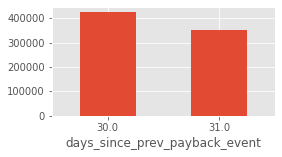

In [67]:
mo_df['date'] = pd.to_datetime(mo_df['date'])
mo_df = mo_df.sort_values(by=['unique_id', 'date'], ascending=[True, True]).reset_index(drop=True)
mo_df['prev_date'] = mo_df.groupby('unique_id')['date'].shift(1)
mo_df['days_since_prev_payback_event'] = (mo_df['date'] - mo_df['prev_date']).dt.days

plt.figure(figsize=(4,2))
mo_df['days_since_prev_payback_event'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)

**3.d Is status always increasing by 1 or 0?**<br>
Results: About 13K users have jumping status column. As this should be impossible, we remove the unique_ids from both data sets.
Example: Status going from 1 to 0, this should not be possible (assuming late payments cannot be made up for)

In [68]:
# get status from previous period for each unique_id
mo_df = mo_df.sort_values(by=['unique_id', 'date'], ascending=[True, True]).reset_index(drop=True)
mo_df['prev_status'] = mo_df.groupby('unique_id')['status'].shift(1)
mo_df['status_delta_previous_period'] = mo_df['status'] - mo_df['prev_status'] 

# Count how often status_delta_previous_period is not 0 or 1 or NaN
print(mo_df[~mo_df['status_delta_previous_period'].isin([0, 1, np.nan])].groupby('status_delta_previous_period').size())

# Explored examples where the status changes by -3, -2, -1, 2, 3, 4. Seems like corruption in the data.
example_user = list(mo_df.query('status_delta_previous_period==-3')['unique_id'])[0]
mo_df.query(f'unique_id == {example_user}')

# Identify users with corrupted status and remove from analysis (13K unique_ids)
unique_ids_for_removal = mo_df[mo_df['status_delta_previous_period'].isin([-3, -2, -1, 2, 3, 4])]['unique_id'].unique()
print('Removed number of unique_ids: ', len(unique_ids_for_removal))
mo_df = mo_df[~mo_df['unique_id'].isin(unique_ids_for_removal)]
ap_df = ap_df[~ap_df['unique_id'].isin(unique_ids_for_removal)]

status_delta_previous_period
-3.0       49
-2.0     3317
-1.0    14314
 2.0       22
 3.0       29
 4.0      182
dtype: int64
Removed number of unique_ids:  12956


## 4. is_bad_12m missing values
**4.a replace missing values with correctly calculated values**<br>
Results: Fixed 4K values. See helper_functions.py for details<br>


In [69]:
# Supress warnings for this cell, to get rid of .iloc warnings
warnings.filterwarnings("ignore")


# Get list of users where is_bad_12m is missing
unique_id_missing_is_bad_12m = list(ap_df[ap_df['is_bad_12m'].isnull()].unique_id)
print(f'Number of unique_id with missing is_bad_12m: {len(unique_id_missing_is_bad_12m)}')

# Checking a few examples, I cannot see a reason why is_bad_12m is missing. I was suspecting that not enough time passed, but this is not the case
mo_df.query(f'unique_id=={unique_id_missing_is_bad_12m[0]}')
            
# See helper_functions.py for details
ap_df = add_xmonth_default_flag(ap_df, mo_df, 12, 3)

# Confirm that new column is_bad_12m_new matches is_bad_12m where available to confirm my method is correct
pd.crosstab(ap_df['is_bad_12m'].fillna(999), ap_df['is_bad_12m_new'].fillna(999))

# Replace is_bad_12m with is_bad_12m_new
ap_df['is_bad_12m'] = ap_df['is_bad_12m_new']
ap_df = ap_df.drop(columns=['is_bad_12m_new'])

Number of unique_id with missing is_bad_12m: 3764


## 5. Dates: ##
**5.a Cast to datetime** <br>
**5.b Confirm data size over time (development, monitor, post-deployment)**<br>

Text(0.5, 1.0, 'Number of payback events and granted loans over time')

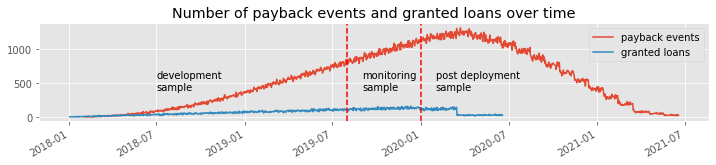

In [70]:
mo_df["date"] = pd.to_datetime(mo_df["date"])
ap_df["origination_date"] = pd.to_datetime(ap_df["origination_date"])

plt.figure(figsize=(12,2))

mo_df.groupby("date").size().plot()
ap_df.groupby("origination_date").size().plot()

# add verticle lines on 2019-08-01 and 2020-01-01
plt.axvline(x=pd.to_datetime("2019-08-01"), color="red", linestyle="--")
plt.axvline(x=pd.to_datetime("2020-01-01"), color="red", linestyle="--")
# add text at 2018-07 saying 'development sample'
plt.text(pd.to_datetime("2018-07-01"), 400, "development\nsample")
plt.text(pd.to_datetime("2019-09-01"), 400, "monitoring\nsample")
plt.text(pd.to_datetime("2020-02-01"), 400, "post deployment\nsample")

plt.legend(["payback events", "granted loans"])
plt.xlabel("")
plt.title("Number of payback events and granted loans over time")

## 6. Unique_id ##

**6.a Remove duplicates in application.csv**<br>
Results: 5K duplicates in application.csv -> drop


In [71]:
# 1. monthly_outcome.csv: Unique identifier should by unique_id and date -> No duplicates
print(f'Duplicates in monthly_outcome.csv:', mo_df.duplicated(subset=['unique_id','date']).sum())

# 2. application.csv: Unique identifier should by unique_id -> 5K duplicates -> Dropped
print(f'Duplicates in application.csv:',ap_df.duplicated(subset=['unique_id']).sum())

# Have a look at the duplicated unique_ids -> They appear to be perfect copies of entire rows
ap_df[ap_df.duplicated(subset=['unique_id'],keep=False)].sort_values('unique_id')
# Drop duplicates and rerun the check to confirm they are all gone
ap_df = ap_df.drop_duplicates()
print(f'Duplicates in application.csv after drop:',ap_df.duplicated(subset=['unique_id']).sum())

Duplicates in monthly_outcome.csv: 0
Duplicates in application.csv: 4565
Duplicates in application.csv after drop: 0


**6.b Confirm that unique_ids between 2 datasets match 1 to 1**<br>
Results: Unique_ids in the 2 datasets are identical<br>

In [72]:
#  Number unique_id in monthly_outcome.csv and application.csv, and do they match?
# Yes, there is the same 70K unique_id in both files
print("Number of unique_id in mo_df:", mo_df['unique_id'].nunique())
print("Number of unique_id in ap_df:", ap_df['unique_id'].nunique())
print("Number of unique_id in both:", len(set(mo_df['unique_id']).intersection(set(ap_df['unique_id']))))

Number of unique_id in mo_df: 57709
Number of unique_id in ap_df: 57709
Number of unique_id in both: 57709


## 7. Numerical features ##
**7.a Plot distributions (after replacing implausible values)**

age_oldest_account
-999997.0      2
 6.0          77
 7.0          84
 8.0          93
 9.0         108
            ... 
 751.0         1
 754.0         1
 755.0         1
 756.0         1
 757.0         2
Length: 487, dtype: int64
total_value_of_mortgage
-999997.0     40379
 0.0           1278
 72.0             1
 211.0            1
 273.0            1
              ...  
 1862527.0        1
 2019546.0        1
 3175345.0        1
 4085395.0        1
 4389933.0        1
Length: 15496, dtype: int64
current_utilisation
-999999.0      84
-999997.0    2068
 0.0         3263
 1.0          375
 2.0          390
             ... 
 9544.0         1
 9576.0         1
 9624.0         1
 9748.0         1
 9940.0         1
Length: 1827, dtype: int64
months_since_2_payments_missed
-999997.0    40683
 0.0           542
 1.0           327
 2.0           283
 3.0           277
             ...  
 68.0          172
 69.0          148
 70.0          149
 71.0          128
 72.0           39
Length: 74,

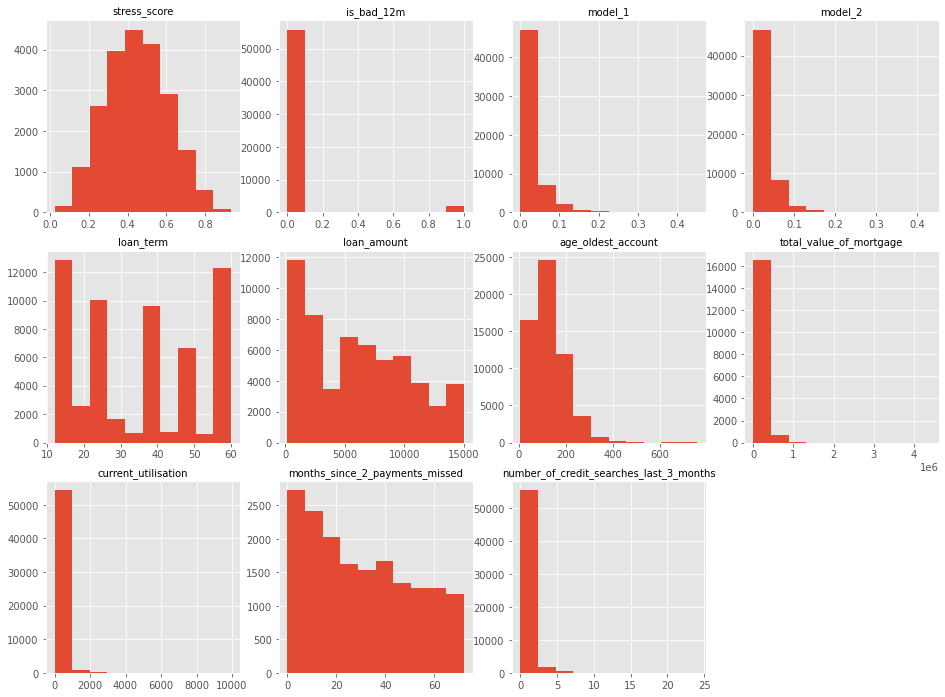

In [73]:
columns_to_replace_low_values = [
    'age_oldest_account', 
    'total_value_of_mortgage', 
    'current_utilisation', 
    'months_since_2_payments_missed', 
    'number_of_credit_searches_last_3_months'
]

# Loop through each column and print the groupby and size -> -999997.0 and -999999 are implausible low values
for column in columns_to_replace_low_values:
    print(ap_df.groupby(column).size().sort_index())

# Replace low values with NaN
ap_df[columns_to_replace_low_values] = ap_df[columns_to_replace_low_values].replace({-999997.0: np.nan, -999999:np.nan})


# Take all numerical columns (except for unique_id) from ap_df and plot they distributions in a plt.Subplot
plt.figure(figsize=(16, 12))
features = ap_df.columns
# remove unique_id and origination_date
features = [x for x in features if x not in ['unique_id', 'origination_date']]
print(len(features))

# plot features in a subplot
# Distribution Looks good for all features

for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    ap_df[feature].hist()
    plt.title(feature, fontsize=10)

In [74]:
# Write csv _cleaned
mo_df.to_csv("./data/monthly_outcome_cleaned.csv", index=False)
ap_df.to_csv("./data/application_cleaned.csv", index=False)